In [12]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
import pandas as pd

import matplotlib.pyplot as plt

import pandas as pd

In [13]:
# load data
df=pd.read_csv('data/BTC-all.csv')
timeseries = df['Adj Close'].values.astype('float32')

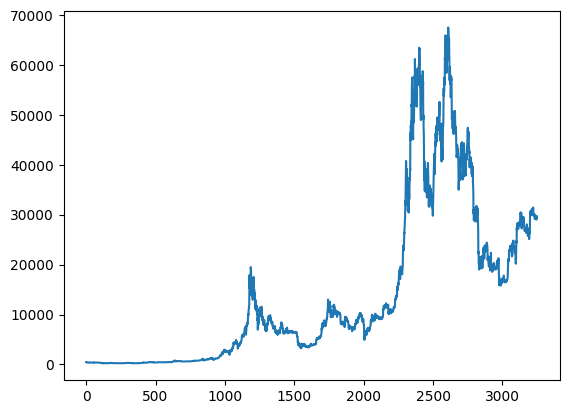

In [14]:
plt.plot(timeseries)
plt.show()

In [15]:
# train-test split for time series
train_size = int(len(timeseries) * 0.7)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [16]:
import torch
def create_dataset(dataset, lookback):    
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [17]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2274, 1]) torch.Size([2274, 1])
torch.Size([974, 1]) torch.Size([974, 1])


C:\Users\nptu\AppData\Local\Temp\ipykernel_6200\2519058128.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


In [18]:
import torch.nn as nn
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    # x, _ = self.lstm(x)
    # # extract only the last time step
    # x = x[:, -1, :]
    # x = self.linear(x)

In [19]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 6528.3623, test RMSE 37254.9531
Epoch 100: train RMSE 5790.6045, test RMSE 36265.4531
Epoch 200: train RMSE 5094.0669, test RMSE 35278.6406
Epoch 300: train RMSE 4452.4834, test RMSE 34306.8633
Epoch 400: train RMSE 3917.0566, test RMSE 33395.7656
Epoch 500: train RMSE 3453.2415, test RMSE 32549.5664
Epoch 600: train RMSE 3105.1875, test RMSE 31762.7109
Epoch 700: train RMSE 2950.2397, test RMSE 31276.4707
Epoch 800: train RMSE 2882.0000, test RMSE 31115.6777
Epoch 900: train RMSE 2867.2024, test RMSE 31075.0352
Epoch 1000: train RMSE 2989.7971, test RMSE 31220.3398
Epoch 1100: train RMSE 2971.3582, test RMSE 31101.6602
Epoch 1200: train RMSE 2935.7751, test RMSE 30931.5410
Epoch 1300: train RMSE 2938.4985, test RMSE 30974.9121
Epoch 1400: train RMSE 2957.1362, test RMSE 30960.0430
Epoch 1500: train RMSE 2996.3420, test RMSE 30996.2559
Epoch 1600: train RMSE 3052.7212, test RMSE 31061.5664
Epoch 1700: train RMSE 2973.9065, test RMSE 30827.3047
Epoch 1800: train RMSE